In [51]:
import ccxt
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import talib

from scipy.interpolate import interp1d
import dateutil.parser
from talib import RSI

In [52]:
millis = {
    '1m': 60_000,
    '1h': 60_000 * 60,
    '1d': 60_000 * 1440
}

sym = 'XBTUSD'
level = '1m'
limit = 1000
since = None # get latest OHLC data

api = ccxt.bitmex()

candles = []

while True:     
    
    
    response = api.fetchOHLCV(
        sym,
        since=since,
        limit=limit,
        timeframe=level,
    )
    candles = response + candles
    min_time = min(x[0] for x in response)    
    since = min_time - limit * millis[level]
    
    if len(candles) >= 20_000:
        break
    

columns = 'time open high low close vol'.split()
df = pd.DataFrame(candles, columns=columns)

df = df.drop_duplicates()
df = df.sort_values('time')
df = df.reset_index(drop=True)

def to_datetime(x):
    return datetime.datetime.fromtimestamp(x / 1000)

df['time'] = df['time'].apply(to_datetime)
df

,time,open,high,low,close,vol
0,2023-04-20 18:36:00,28577.5,28594.0,28567.0,28575.0,113300.0
1,2023-04-20 18:37:00,28575.0,28572.5,28562.0,28562.0,54100.0
2,2023-04-20 18:38:00,28562.0,28593.0,28561.0,28568.5,254400.0
3,2023-04-20 18:39:00,28568.5,28594.5,28573.0,28585.0,92800.0
4,2023-04-20 18:40:00,28585.0,28580.5,28561.0,28571.0,319900.0
...,...,...,...,...,...,...
19995,2023-05-04 15:51:00,28812.5,28827.5,28810.0,28815.0,1801300.0
19996,2023-05-04 15:52:00,28815.0,28819.5,28801.0,28806.0,675400.0
19997,2023-05-04 15:53:00,28806.0,28815.5,28803.5,28815.5,300700.0
19998,2023-05-04 15:54:00,28815.5,28842.5,28803.5,28808.5,895900.0


**Calculate RSI TA-Lib package**  
- Use default 14 time period for Relative Strength Index (RSI)

In [53]:
df['rsi'] = RSI(df['close'])
df.tail(20)

,time,open,high,low,close,vol,rsi
19980,2023-05-04 15:36:00,28874.5,28867.5,28837.5,28842.0,902200.0,32.506349
19981,2023-05-04 15:37:00,28842.0,28870.5,28838.5,28840.5,617500.0,32.329967
19982,2023-05-04 15:38:00,28840.5,28841.5,28754.5,28775.5,4572500.0,25.797576
19983,2023-05-04 15:39:00,28775.5,28785.0,28670.5,28713.5,5855800.0,21.363506
19984,2023-05-04 15:40:00,28713.5,28729.0,28674.0,28696.0,4158200.0,20.302764
19985,2023-05-04 15:41:00,28696.0,28743.0,28691.0,28731.5,1934700.0,28.101627
19986,2023-05-04 15:42:00,28731.5,28753.5,28725.5,28746.0,1649800.0,31.068704
19987,2023-05-04 15:43:00,28746.0,28758.5,28698.5,28702.5,1601700.0,27.413734
19988,2023-05-04 15:44:00,28702.5,28708.5,28691.0,28698.0,1713400.0,27.059099
19989,2023-05-04 15:45:00,28698.0,28730.0,28681.0,28730.0,3376000.0,33.633895


**Distribution of RSI**

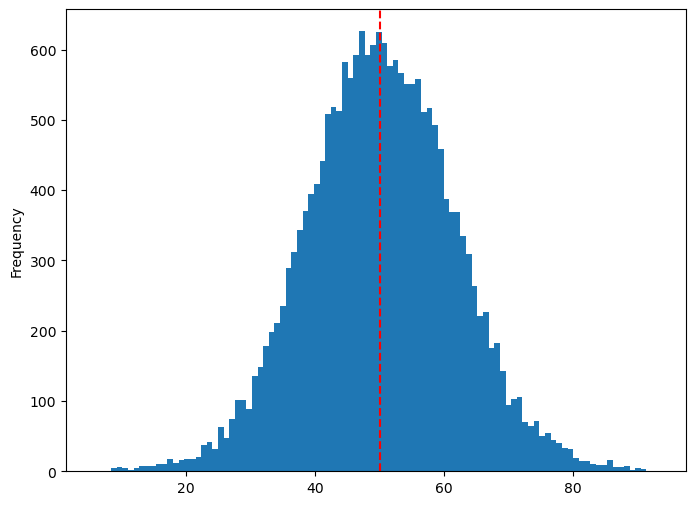

In [54]:
df['rsi'].plot(kind='hist', bins=100, figsize=(8, 6))
plt.axvline(50, color='red', linestyle='--')

**Plot close price vs RSI for a time period**

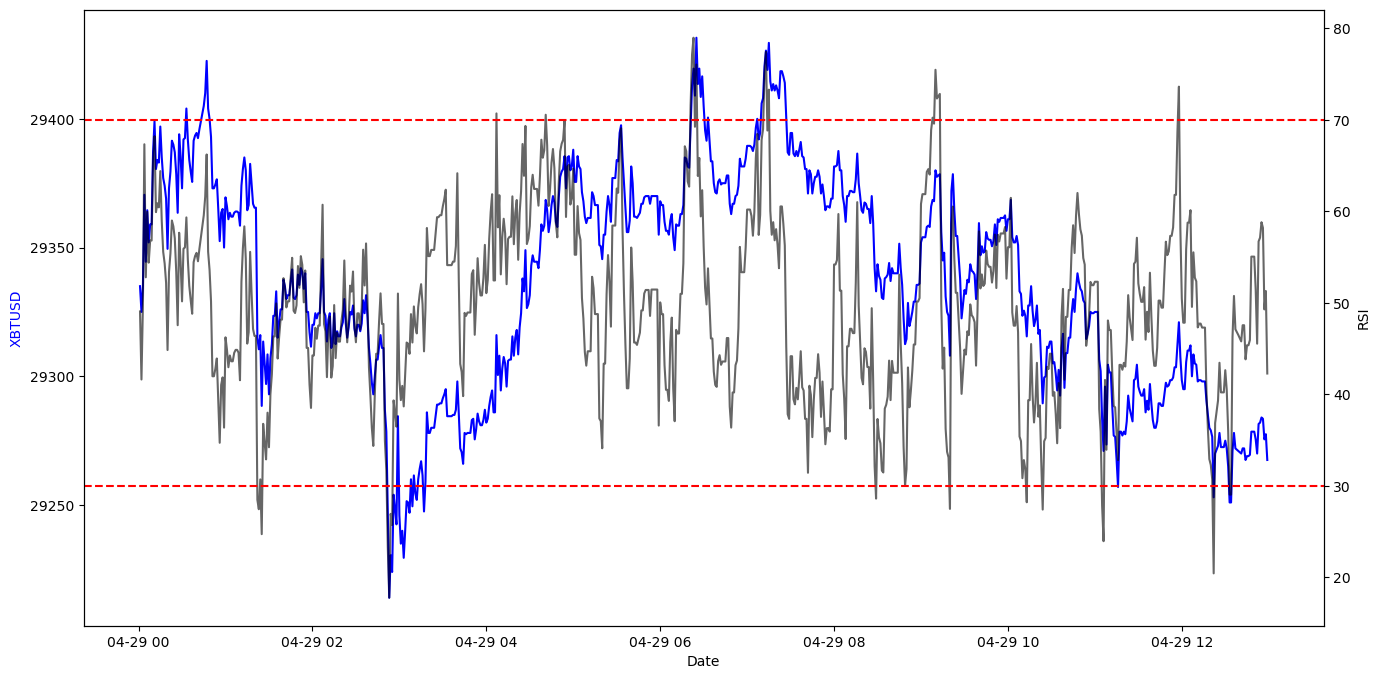

In [55]:
start_time = datetime.datetime(2023, 4, 29, 0)
end_time = datetime.datetime(2023, 4, 29, 13)

xf = df[(df['time'] > start_time) & (df['time'] < end_time)]

fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

ax1.plot(xf['time'], xf['close'], 'b-')
ax2.plot(xf['time'], xf['rsi'], 'k-', alpha=0.6)

ax1.set_xlabel('Date')
ax1.set_ylabel('XBTUSD', color='b')
ax2.set_ylabel('RSI', color='k')

ax2.axhline(70, color='red', linestyle='--')
ax2.axhline(30, color='red', linestyle='--')

**Trade programmatically using CCXT library**

In [56]:
API = ccxt.bitmex({'apiKey':'Ds9XugYf2Luk282-1RTAO0wb', 'secret':'CE7m1gliS0H1HWMhoB6qqbFazQQhDAWr1xZTr7HLmWejsxl9'})

**Load historical candle data from API**

In [57]:
# Get previous trades in time buckets.

candles = API.publicGetTradeBucketed(params={
    'binSize': '1m',
    'symbol': 'XBTUSD',
    'reverse': True 
})

candles[:2]

[{'timestamp': '2023-05-04T13:55:00.000Z',
  'symbol': 'XBTUSD',
  'open': '28815.5',
  'high': '28842.5',
  'low': '28803.5',
  'close': '28808.5',
  'trades': '133',
  'volume': '895900',
  'vwap': '28819.95',
  'lastSize': '100',
  'turnover': '3108613295',
  'homeNotional': '31.086132950000007',
  'foreignNotional': '895900'},
 {'timestamp': '2023-05-04T13:54:00.000Z',
  'symbol': 'XBTUSD',
  'open': '28806',
  'high': '28815.5',
  'low': '28803.5',
  'close': '28815.5',
  'trades': '32',
  'volume': '300700',
  'vwap': '28807.15',
  'lastSize': '14800',
  'turnover': '1043838838',
  'homeNotional': '10.43838838',
  'foreignNotional': '300700'}]

**RSI strategy idea**

In [58]:
def iso_to_unix(ts):
    return round(1000 * dateutil.parser.parse(ts).timestamp())

candle = {iso_to_unix(c['timestamp']): c['close'] for c in candles}
times, closes = zip(*sorted(candle.items()))

# sort the candles in chronological order in a list, from the least recent to the most recent.

In [59]:
def hypo_rsi(closes, ret):
    return RSI(np.append(np.float64(closes), [np.float64(closes[-1]) * (1 + ret)]))[-1]


returns = np.linspace(-.02, .02, 100)
rsi_data = [hypo_rsi(closes, r) for r in returns]

# this function calculates what the RSI value would be for a price return based on current closing prices.

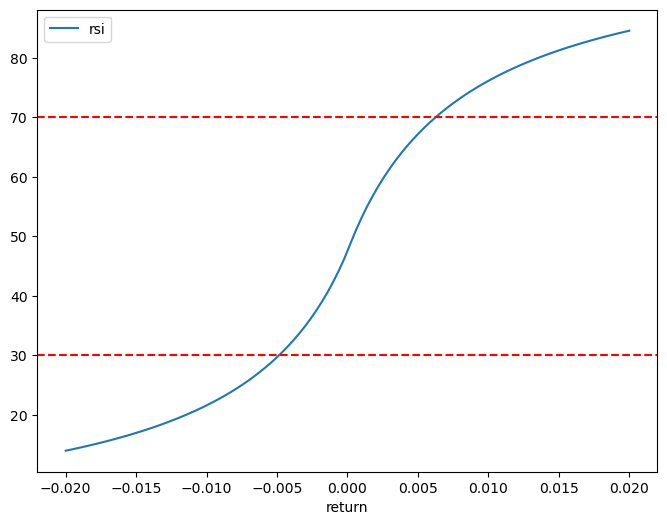

In [60]:
rsi = pd.DataFrame({'return': returns, 'rsi': rsi_data})

rsi.plot(x='return', y='rsi', figsize=(8, 6))
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='red', linestyle='--')

In [61]:
func = interp1d(rsi_data, returns, kind='cubic')

func(30), func(70)

(array(-0.00486024), array(0.00624951))

**Let's calculate manually the RSI with Exponential Weighting Moving Average (ewm)**

In [62]:
df['close_delta'] = df['close'] - df['close'].shift(1)

In [63]:
up = df['close_delta'].clip(lower=0)
down = -1 * df['close_delta'].clip(upper=0)
df['up_ewm'] = up.ewm(alpha=1/14, min_periods = 14).mean()
df['down_ewm'] = down.ewm(alpha=1/14, min_periods = 14).mean()


df['rs_ewm'] = df['up_ewm'] / df['down_ewm']
df['rsi_ewm'] = 100 - (100/(1 + df['rs_ewm']))


**Let's do the opposite calculation, what return do i need to get a given RSI ?**  

In [64]:
def hypo_return(rsi):
    return 100/(100-rsi) - 1


rsi = np.linspace(30, 70, 41)
rs_data = [hypo_return(rsi) for rsi in rsi]

In [65]:
d = {'RSI': rsi, 'RS': rs_data}
cf = pd.DataFrame(d)

# I take the data from the last manual calculation of the relative strenght.
last_rs_value = df.iloc[len(df)-1,10]  
last_up_ewm = df.iloc[len(df)-1,8]
last_down_ewm = df.iloc[len(df)-1,9]

cf['RS_delta'] = cf['RS'] - last_rs_value

In [66]:
down_ewm = []
up_ewm = []

#RS_delta : difference between the most recent RS and RS calculated with RSI levels ranging from 30 to 70.
for i in range(0,len(cf)):
    
    if cf['RS_delta'][i] < 0:
        down_ewm.append(-(last_up_ewm / cf['RS'][i])) 
    if cf['RS_delta'][i] > 0:
        down_ewm.append(0)
        
    if cf['RS_delta'][i] > 0:
        up_ewm.append((last_down_ewm * cf['RS'][i]))
    if cf['RS_delta'][i] < 0:
        up_ewm.append(0)
        
    
    
        
cf['down_ewm_delta'] = down_ewm
cf['up_ewm_delta'] = up_ewm
cf

,RSI,RS,RS_delta,down_ewm_delta,up_ewm_delta
0,30.0,0.428571,-0.475925,-18.993697,0.000000
1,31.0,0.449275,-0.455221,-18.118412,0.000000
2,32.0,0.470588,-0.433908,-17.297832,0.000000
3,33.0,0.492537,-0.411959,-16.526983,0.000000
4,34.0,0.515152,-0.389345,-15.801479,0.000000
5,35.0,0.538462,-0.366035,-15.117433,0.000000
6,36.0,0.562500,-0.341996,-14.471388,0.000000
7,37.0,0.587302,-0.317195,-13.860266,0.000000
8,38.0,0.612903,-0.291593,-13.281307,0.000000
9,39.0,0.639344,-0.265152,-12.732039,0.000000
